In [1]:
import torch
import torchvision
import numpy as np
import math
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, RandomSampler, random_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import librosa
import IPython
import soundfile as sf
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import glob
import os, random
import pickle
!pip install simplejson
import simplejson
import pandas as pd
import ast
from matplotlib.pyplot import figure
import copy
from itertools import combinations,product
import seaborn as sns
import gzip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = "/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/"


## Problem 1: Network compression using SVD - MNIST Classification with 6 D values

### Loading data and data loader for network

In [4]:
mnist_train=torchvision.datasets.MNIST('mnist',
                train=True,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ]))

mnist_test=torchvision.datasets.MNIST('mnist',
                train=False,
                download=True,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ]))

print('MNIST Train shape', mnist_train.data.shape, type(mnist_train))

MNIST Train shape torch.Size([60000, 28, 28]) <class 'torchvision.datasets.mnist.MNIST'>


In [5]:
batch_size_train = 128 # batch size train set
batch_size_test = 128 # batch size test set

# Dataloader for laoding in data
# Steps to do this is to convert raw data to tensor
# Then tensor to dataset object
# And then from dataset object to dataloader

# Our MNIST is already in tensorDataset format
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
                                             batch_size=batch_size_train, 
                                             shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
                                             batch_size=batch_size_test, 
                                             shuffle=False)

In [6]:
# Get device
if(torch.cuda.is_available()):
    device = torch.device('cuda')
    print(f"Using {device} device")
    print(torch.cuda.get_device_name(0))

torch.backends.cudnn.enabled = False
# Set torch random seed 
torch.manual_seed(100)
np.random.seed(100)

#Uniform initialization      
def weights_init_uniform_rule(m):    
    if isinstance(m, nn.Linear):
        n = m.in_features # number of inputs
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)   
        
# Xavier initialization      
def xavier_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
    
# Kaiming He initialization
def he_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)
        

Using cuda device
Tesla T4


### Define and run network

#### Baseline model

In [31]:
class baseline_q1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fp_input = nn.Linear(28*28, 1024)
        self.fp1 = nn.Linear(1024, 1024)
        self.fp2 = nn.Linear(1024, 1024)
        self.fp3 = nn.Linear(1024, 1024)
        self.fp4 = nn.Linear(1024, 1024)
        self.fp_output = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.2)
        self.ReLU = nn.ReLU()
        
    def forward(self, input):
        to_save_layerop = {}
        input = self.fp_input(input)
        input = self.ReLU(input)
        to_save_layerop['fp_input'] = input    
        
        input = self.fp1(input)
        input = self.ReLU(input)
        to_save_layerop['fp1'] = input
        
        input = self.fp2(input)
        input = self.ReLU(input)
        to_save_layerop['fp2'] = input
        
        input = self.fp3(input)
        input = self.ReLU(input)
        to_save_layerop['fp3'] = input
        
        input = self.fp4(input)
        input = self.ReLU(input)
        to_save_layerop['fp4'] = input

        input = self.fp_output(input)
        to_save_layerop['fp_output_before_softmax'] = input

        # MOST IMPORTANT REALIZATION...USE SOFTMAX AFTER CALCULATING CCE LOSS, THE CCE LOSS EXPECTS LOGITS AND NOT SOFTMAX OUTPUTS.
        return input, to_save_layerop    

In [32]:
def run_network(net, epochs, loss_criteria, optimizer, validation_process=True):
    # A minor difference is that the implementation of CrossEntrypyLoss implicitly applies a softmax activation followed by a log transformation 
    # but NLLLoss does not.

    # To keep best performance value
    max_performance = float('-inf')
    
    # For early stopping
    tolerance_level = 0
    early_stopping_activated = 0
    epoch = 0
    MAX_MODEL = None
    MAX_PERFORMANCE_WEIGHTS = None

    train_loss_all = []
    valid_loss_all = []
    train_accuracy_all = []
    valid_accuracy_all = []

    print(len(train_loader))

    while( epoch <= epochs and early_stopping_activated == 0 ):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        val_acc = 0
        
        # Training Part
        # Always have this line to ensure proper training
        net.train()
        actual_labels_train = []
        pred_labels_train = []
        all_targets = []
        all_preds = []

        for i, (data, actual) in enumerate(train_loader):
            # Reshape to single dimension
            data = data.reshape(-1, 784)

            # Push all variables to cuda
            if(torch.cuda.is_available()):
                data, actual =  data.float().to(device), actual.to(device)

            output, _ = net(data.float())
            loss =  loss_criteria(output, actual)
            # Track loss
            train_loss += loss.item()
            train_predictions = func.softmax(output, dim = 1).argmax(dim=1, keepdim=True)            
            actual_labels_train.append(actual.cpu().numpy())
            pred_labels_train.append(train_predictions.cpu().numpy())

            optimizer.zero_grad() # reset gradients
            loss.backward()
            optimizer.step()

        all_targets = np.concatenate(actual_labels_train, axis=0)
        all_preds = np.concatenate(pred_labels_train, axis=0)
        train_acc = accuracy_score(all_preds, all_targets)
        train_accuracy_all.append(train_acc)


        # Evaluation Part
        # Always have this line to ensure proper evaluation 
        if(validation_process):
          net.eval()
          
          actual_labels_all = []
          pred_labels_all = []
          all_targets = []
          all_preds = []
          # Now do validation and keep track of valid loss
          with torch.no_grad():
              for i, (data, labels) in enumerate(valid_loader):
                  # Reshape to single dimension
                  data = data.reshape(-1, 784)

                  if(torch.cuda.is_available()):
                      data, labels = data.float().to(device), labels.to(device)

                  # FP     
                  val_logits, _ = net.forward(data)
                  v_loss = loss_criteria(val_logits, labels)
                  valid_loss += v_loss.item()
                  val_predictions = func.softmax(val_logits, dim = 1).argmax(dim=1, keepdim=True)
                  actual_labels_all.append(labels.cpu().numpy())
                  pred_labels_all.append(val_predictions.cpu().numpy())
                  
          all_targets = np.concatenate(actual_labels_all, axis=0)
          all_preds = np.concatenate(pred_labels_all, axis=0)
          val_acc = accuracy_score(all_preds, all_targets)
          valid_accuracy_all.append(val_acc)
          
          if(epoch % 5 == 0):
            print(f'Epoch {epoch} \t Train loss(on avg per batch): {round(train_loss/len(train_loader), 6) } \t Train Accuracy: {round(train_acc*100, 6)}% \t Validation loss(on avg per batch): {round(valid_loss/len(valid_loader),6)} \t Validation Accuracy: {round(val_acc*100,6)}%')

          train_loss_all.append(train_loss/len(train_loader))
          valid_loss_all.append(valid_loss/len(valid_loader)) 
          
          if(val_acc*100 > max_performance):
              max_performance = val_acc*100
              tolerance_level = 0
              # Save Model
              MAX_PERFORMANCE_WEIGHTS = net.state_dict()
              MAX_MODEL = net
              
          else:
              tolerance_level+=1
              if(tolerance_level >= 10):
                  early_stopping_activated = 1
                  print('Early Stopping activated - no improvement in validation accuracy for the past 10 epochs. Using model stage before 10 epochs for further use!')
        epoch+=1

    if(not validation_process):
        # Save Model at end
        MAX_PERFORMANCE_WEIGHTS = net.state_dict()
        MAX_MODEL = net

    print('Best Performance on Validation data achived till now :', max_performance)
    
    return MAX_MODEL, MAX_PERFORMANCE_WEIGHTS, train_accuracy_all, valid_accuracy_all

In [34]:
net = None
net = baseline_q1()
if(torch.cuda.is_available()):
  net = net.float().to(device)
else:
  net = net.float()
net.apply(he_weights)
loss_func = nn.CrossEntropyLoss() # Here Sparse CLE is correct, but in pytorch nn.CrossEntropyLoss accepts ground truth labels directly as integers in [0, N_CLASSES] (no need to onehot encode the labels):
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
print(net)
torch.cuda.empty_cache()

q1_net_baseline, q1_weights_baseline, train_accuracy_all_baseline, valid_accuracy_all_baseline = run_network(net, epochs = 1, loss_criteria = loss_func, optimizer = optimizer)

baseline_q1(
  (fp_input): Linear(in_features=784, out_features=1024, bias=True)
  (fp1): Linear(in_features=1024, out_features=1024, bias=True)
  (fp2): Linear(in_features=1024, out_features=1024, bias=True)
  (fp3): Linear(in_features=1024, out_features=1024, bias=True)
  (fp4): Linear(in_features=1024, out_features=1024, bias=True)
  (fp_output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (ReLU): ReLU()
)
469
Epoch 0 	 Train loss(on avg per batch): 0.262295 	 Train Accuracy: 92.883333% 	 Validation loss(on avg per batch): 0.132191 	 Validation Accuracy: 96.0%
Best Performance on Validation data achived till now : 96.98


In [43]:
# torch.save(q1_weights_baseline, '/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q1 Baseline Weights')
net = None
net = baseline_q1()
net.load_state_dict( torch.load('/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q1 Baseline Weights', map_location=torch.device('cpu')) )


<All keys matched successfully>

#### 6 Other D values

In [44]:
# net1 = copy.deepcopy(net)
# print(sum(p.numel() for p in net.parameters()))

In [45]:
w1 = net.fp_input.weight
w2 = net.fp1.weight
w3 = net.fp2.weight
w4 = net.fp3.weight
w5 = net.fp4.weight

bias1 = net.fp_input.bias
bias2 = net.fp1.bias
bias3 = net.fp2.bias
bias4 = net.fp3.bias
bias5 = net.fp4.bias


U1, S1, V_t1 = torch.linalg.svd(w1)
U1, S1, V_t1 = U1.detach().cpu().numpy(), S1.detach().cpu().numpy(), V_t1.detach().cpu().numpy()

U2, S2, V_t2 = torch.linalg.svd(w2)
U2, S2, V_t2 = U2.detach().cpu().numpy(), S2.detach().cpu().numpy(), V_t2.detach().cpu().numpy()

U3, S3, V_t3 = torch.linalg.svd(w3)
U3, S3, V_t3 = U3.detach().cpu().numpy(), S3.detach().cpu().numpy(), V_t3.detach().cpu().numpy()

U4, S4, V_t4 = torch.linalg.svd(w4)
U4, S4, V_t4 = U4.detach().cpu().numpy(), S4.detach().cpu().numpy(), V_t4.detach().cpu().numpy()

U5, S5, V_t5 = torch.linalg.svd(w5)
U5, S5, V_t5 = U5.detach().cpu().numpy(), S5.detach().cpu().numpy(), V_t5.detach().cpu().numpy()

In [55]:
# Predictions using Low-rank approximate of weight matrix of input to h5 hidden layers
def convert_low_rank_matrix(low_rank_value, U, S, V_t):
  U_hat = U[:, :low_rank_value]
  S_hat = S[:low_rank_value]
  S_hat = np.diag(S_hat)
  V_t_hat = V_t[:low_rank_value, :]
  w_hat = np.dot(U_hat, np.dot(S_hat, V_t_hat))
  return w_hat

def count_total_parameters_active(net):
  total_nonzero = 0
  for name, p in net.named_parameters():
    tensor = p.data.cpu().numpy()
    nz_count = np.count_nonzero(tensor)
    total_nonzero += nz_count
  return total_nonzero


def predict_from_low_rank_approx(d_net, loss_criteria, low_rank_value, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1):
  w1_hat = convert_low_rank_matrix(low_rank_value, U1, S1, V_t1)
  # print(w1_hat)
  w2_hat = convert_low_rank_matrix(low_rank_value, U2, S2, V_t2)
  w3_hat = convert_low_rank_matrix(low_rank_value, U3, S3, V_t3)
  w4_hat = convert_low_rank_matrix(low_rank_value, U4, S4, V_t4)
  w5_hat = convert_low_rank_matrix(low_rank_value, U5, S5, V_t5)
  # Evaluation Part
  # Always have this line to ensure proper evaluation 
  if(validation_process):
    d_net.eval()

    actual_labels_all = []
    pred_labels_all = []
    all_targets = []
    all_preds = []
    valid_accuracy_all = []
    valid_loss_all = []
    valid_loss = 0
    # Now do validation and keep track of valid loss
    with torch.no_grad():
        for i, (data, labels) in enumerate(valid_loader):
            # Reshape to single dimension
            data = data.reshape(-1, 784)

            if(torch.cuda.is_available()):
                data, labels = data.float().to(device), labels.to(device)

            # FP and change weights to lower rank matrix
            d_net.fp_input.weight = nn.Parameter(torch.tensor(w1_hat))
            d_net.fp1.weight = nn.Parameter(torch.tensor(w2_hat))
            d_net.fp2.weight = nn.Parameter(torch.tensor(w3_hat))
            d_net.fp3.weight = nn.Parameter(torch.tensor(w4_hat))
            d_net.fp4.weight = nn.Parameter(torch.tensor(w5_hat)) 
            if(torch.cuda.is_available()):
              d_net = d_net.to(device)         
            val_logits, _ = d_net.forward(data)
            if(torch.cuda.is_available()):
              val_logits = val_logits.to(device)
            v_loss = loss_criteria(val_logits, labels)
            valid_loss += v_loss.item()
            val_predictions = func.softmax(val_logits, dim = 1).argmax(dim=1, keepdim=True)
            actual_labels_all.append(labels.cpu().numpy())
            pred_labels_all.append(val_predictions.cpu().numpy())
            
    all_targets = np.concatenate(actual_labels_all, axis=0)
    all_preds = np.concatenate(pred_labels_all, axis=0)
    val_acc = accuracy_score(all_preds, all_targets)
    valid_accuracy_all.append(val_acc)    
    valid_loss_all.append(valid_loss/len(valid_loader)) 
  
  total_params = count_total_parameters_active(d_net)
  return valid_accuracy_all, total_params

In [56]:
# tU, tS, tV =  torch.linalg.svd(w1)
# print(tU.shape, tS.shape, tV.shape)
# rec = tU[:,:20]@(torch.diag(tS[:20])@tV[:20,:])
# print( rec.shape, rec )

In [57]:
test_acc_d10, total_params_d10  = predict_from_low_rank_approx(net, loss_func, 10, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)
test_acc_d20, total_params_d20  = predict_from_low_rank_approx(net, loss_func, 20, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)
test_acc_d50, total_params_d50  = predict_from_low_rank_approx(net, loss_func, 50, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)
test_acc_d100, total_params_d100  = predict_from_low_rank_approx(net, loss_func, 100, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)
test_acc_d200, total_params_d200  = predict_from_low_rank_approx(net, loss_func, 200, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)
test_acc_d784, total_params_d784  = predict_from_low_rank_approx(net, loss_func, 784, U1, S1, V_t1, U2, S2, V_t2, U3, S3, V_t3, U4, S4, V_t4, U5, S5, V_t5, validation_process=1)


#### Bar-chart analysis of test accuracies and number of parameters in different D values and baseline model

In [58]:
compare_df = pd.DataFrame(columns = ['D-value', 'Number of parameters', 'Test accuracy'])
compare_df['D-value'] = [10, 20, 50, 100, 200, 784, 'Baseline']
compare_df['Number of parameters'] = [total_params_d10, total_params_d20, total_params_d50, total_params_d100, total_params_d200, total_params_d784, sum(p.numel() for p in net.parameters())]
compare_df['Test accuracy'] = [test_acc_d10[0]*100, test_acc_d20[0]*100, test_acc_d50[0]*100, test_acc_d100[0]*100, test_acc_d200[0]*100, test_acc_d784[0]*100, valid_accuracy_all_baseline[-1]*100]


In [59]:
# sns.barplot(data = compare_df, x='D-value', y='Number of parameters')

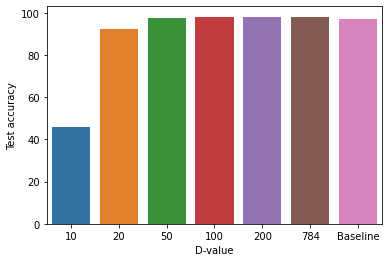

In [60]:
sns.barplot(data = compare_df, x='D-value', y='Test accuracy')


## Problem 2

In [98]:
# Should be W.t*X
# Load previous weights
net = None
net = baseline_q1()
net.load_state_dict( torch.load('/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q1 Baseline Weights', map_location=torch.device('cpu')) )


<All keys matched successfully>

In [99]:
class low_rank_nn_q2(nn.Module):
    
    def __init__(self, u1, v1, u2, v2, u3, v3, u4, v4, u5, v5, bias1, bias2, bias3, bias4, bias5):
        super().__init__()
        self.u1 = nn.Parameter(u1, requires_grad=True)
        self.v1 = nn.Parameter(v1, requires_grad=True)
        self.u2 = nn.Parameter(u2, requires_grad=True)
        self.v2 = nn.Parameter(v2, requires_grad=True)
        self.u3 = nn.Parameter(u3, requires_grad=True)
        self.v3 = nn.Parameter(v3, requires_grad=True)
        self.u4 = nn.Parameter(u4, requires_grad=True)
        self.v4 = nn.Parameter(v4, requires_grad=True)
        self.u5 = nn.Parameter(u5, requires_grad=True)
        self.v5 = nn.Parameter(v5, requires_grad=True)

        self.bias1 = nn.Parameter(bias1, requires_grad=True)
        self.bias2 = nn.Parameter(bias2, requires_grad=True)
        self.bias3 = nn.Parameter(bias3, requires_grad=True)
        self.bias4 = nn.Parameter(bias4, requires_grad=True)
        self.bias5 = nn.Parameter(bias5, requires_grad=True)

        # self.u1 = nn.Linear(784, 20) #I, O
        # self.v1 = nn.Linear(20, 1024) # I, O
        
        # self.u2 = nn.Linear(1024, 20)
        # self.v2 = nn.Linear(20, 1024)
        
        # self.u3 = nn.Linear(1024, 20)
        # self.v3 = nn.Linear(20, 1024)
        
        # self.u4 = nn.Linear(1024, 20)
        # self.v4 = nn.Linear(20, 1024)
        
        # self.u5 = nn.Linear(1024, 20)
        # self.v5 = nn.Linear(20, 1024)
        
        self.fp_output = nn.Linear(1024, 10)

        self.dropout = nn.Dropout(0.2)
        self.ReLU = nn.ReLU()
        
    def forward(self, input):
        to_save_layerop = {}
        input = torch.matmul(input, torch.matmul(self.u1, self.v1).T)  + self.bias1 
        input = self.ReLU(input)

        input = torch.matmul(input, torch.matmul(self.u2, self.v2).T)  + self.bias2
        input = self.ReLU(input)

        input = torch.matmul(input, torch.matmul(self.u3, self.v3).T)  + self.bias3
        input = self.ReLU(input)

        input = torch.matmul(input, torch.matmul(self.u4, self.v4).T)  + self.bias4
        input = self.ReLU(input)

        input = torch.matmul(input, torch.matmul(self.u5, self.v5).T)  + self.bias5
        input = self.ReLU(input)

        input = self.fp_output(input)
        to_save_layerop['fp_output_before_softmax'] = input

        # MOST IMPORTANT REALIZATION...USE SOFTMAX AFTER CALCULATING CCE LOSS, THE CCE LOSS EXPECTS LOGITS AND NOT SOFTMAX OUTPUTS.
        return input, to_save_layerop    

In [100]:
# Use weights from d20 of Q1
def get_lower_uv(U, S, V):
  low_rank_value = 20
  U_hat = U[:, :low_rank_value]
  S_hat = S[:low_rank_value]
  S_hat = np.diag(S_hat)
  V_t_hat = np.dot(S_hat, V[:low_rank_value, :])
  return U_hat, V_t_hat


w1 = net.fp_input.weight
w2 = net.fp1.weight
w3 = net.fp2.weight
w4 = net.fp3.weight
w5 = net.fp4.weight
U1, S1, V_t1 = torch.linalg.svd(w1)
U1, S1, V_t1 = U1.detach().cpu().numpy(), S1.detach().cpu().numpy(), V_t1.detach().cpu().numpy()

U2, S2, V_t2 = torch.linalg.svd(w2)
U2, S2, V_t2 = U2.detach().cpu().numpy(), S2.detach().cpu().numpy(), V_t2.detach().cpu().numpy()

U3, S3, V_t3 = torch.linalg.svd(w3)
U3, S3, V_t3 = U3.detach().cpu().numpy(), S3.detach().cpu().numpy(), V_t3.detach().cpu().numpy()

U4, S4, V_t4 = torch.linalg.svd(w4)
U4, S4, V_t4 = U4.detach().cpu().numpy(), S4.detach().cpu().numpy(), V_t4.detach().cpu().numpy()

U5, S5, V_t5 = torch.linalg.svd(w5)
U5, S5, V_t5 = U5.detach().cpu().numpy(), S5.detach().cpu().numpy(), V_t5.detach().cpu().numpy()

U1, V_t1 = get_lower_uv(U1, S1, V_t1)
U2, V_t2 = get_lower_uv(U2, S2, V_t2)
U3, V_t3 = get_lower_uv(U3, S3, V_t3)
U4, V_t4 = get_lower_uv(U4, S4, V_t4)
U5, V_t5 = get_lower_uv(U5, S5, V_t5)


In [101]:
def run_network(net, epochs, loss_criteria, optimizer, validation_process=True):
    # A minor difference is that the implementation of CrossEntrypyLoss implicitly applies a softmax activation followed by a log transformation 
    # but NLLLoss does not.

    # To keep best performance value
    max_performance = float('-inf')
    
    # For early stopping
    tolerance_level = 0
    early_stopping_activated = 0
    epoch = 0
    MAX_MODEL = None
    MAX_PERFORMANCE_WEIGHTS = None

    train_loss_all = []
    valid_loss_all = []
    train_accuracy_all = []
    valid_accuracy_all = []

    print(len(train_loader))

    while( epoch <= epochs and early_stopping_activated == 0 ):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        val_acc = 0
        
        # Training Part
        # Always have this line to ensure proper training
        net.train()
        actual_labels_train = []
        pred_labels_train = []
        all_targets = []
        all_preds = []

        for i, (data, actual) in enumerate(train_loader):
            # Reshape to single dimension
            data = data.reshape(-1, 784)

            # Push all variables to cuda
            if(torch.cuda.is_available()):
                data, actual =  data.float().to(device), actual.to(device)

            output, _ = net(data.float())
            loss =  loss_criteria(output, actual)
            # Track loss
            train_loss += loss.item()
            train_predictions = func.softmax(output, dim = 1).argmax(dim=1, keepdim=True)            
            actual_labels_train.append(actual.cpu().numpy())
            pred_labels_train.append(train_predictions.cpu().numpy())

            optimizer.zero_grad() # reset gradients
            loss.backward()
            optimizer.step()

        all_targets = np.concatenate(actual_labels_train, axis=0)
        all_preds = np.concatenate(pred_labels_train, axis=0)
        train_acc = accuracy_score(all_preds, all_targets)
        train_accuracy_all.append(train_acc)


        # Evaluation Part
        # Always have this line to ensure proper evaluation 
        if(validation_process):
          net.eval()
          
          actual_labels_all = []
          pred_labels_all = []
          all_targets = []
          all_preds = []
          # Now do validation and keep track of valid loss
          with torch.no_grad():
              for i, (data, labels) in enumerate(valid_loader):
                  # Reshape to single dimension
                  data = data.reshape(-1, 784)

                  if(torch.cuda.is_available()):
                      data, labels = data.float().to(device), labels.to(device)

                  # FP     
                  val_logits, _ = net.forward(data)
                  v_loss = loss_criteria(val_logits, labels)
                  valid_loss += v_loss.item()
                  val_predictions = func.softmax(val_logits, dim = 1).argmax(dim=1, keepdim=True)
                  actual_labels_all.append(labels.cpu().numpy())
                  pred_labels_all.append(val_predictions.cpu().numpy())
                  
          all_targets = np.concatenate(actual_labels_all, axis=0)
          all_preds = np.concatenate(pred_labels_all, axis=0)
          val_acc = accuracy_score(all_preds, all_targets)
          valid_accuracy_all.append(val_acc)
          
          if(epoch % 5 == 0):
            print(f'Epoch {epoch} \t Train loss(on avg per batch): {round(train_loss/len(train_loader), 6) } \t Train Accuracy: {round(train_acc*100, 6)}% \t Validation loss(on avg per batch): {round(valid_loss/len(valid_loader),6)} \t Validation Accuracy: {round(val_acc*100,6)}%')

          train_loss_all.append(train_loss/len(train_loader))
          valid_loss_all.append(valid_loss/len(valid_loader)) 
          
          if(val_acc*100 > max_performance):
              max_performance = val_acc*100
              tolerance_level = 0
              # Save Model
              MAX_PERFORMANCE_WEIGHTS = net.state_dict()
              MAX_MODEL = net
              
          else:
              tolerance_level+=1
              if(tolerance_level >= 10):
                  early_stopping_activated = 1
                  print('Early Stopping activated - no improvement in validation accuracy for the past 10 epochs. Using model stage before 10 epochs for further use!')
        epoch+=1

    if(not validation_process):
        # Save Model at end
        MAX_PERFORMANCE_WEIGHTS = net.state_dict()
        MAX_MODEL = net

    print('Best Performance on Validation data achived till now :', max_performance)
    
    return MAX_MODEL, MAX_PERFORMANCE_WEIGHTS, train_accuracy_all, valid_accuracy_all

In [102]:
# Set weights
# U1, V_t1
u1 = torch.tensor(U1) 
v1 = torch.tensor(V_t1) 
u2 = torch.tensor(U2) 
v2 = torch.tensor(V_t2) 
u3 = torch.tensor(U3) 
v3 = torch.tensor(V_t3) 
u4 = torch.tensor(U4) 
v4 = torch.tensor(V_t4) 
u5 = torch.tensor(U5) 
v5 = torch.tensor(V_t5)

bias_input = net.fp_input.bias
bias2 = net.fp1.bias
bias3 = net.fp2.bias
bias4 = net.fp3.bias
bias5 = net.fp4.bias

if(torch.cuda.is_available()):
  u1, v1, u2, v2, u3, v3, u4, v4, u5, v5 =  u1.to(device), v1.to(device), u2.to(device), v2.to(device), u3.to(device), v3.to(device), u4.to(device), v4.to(device), u5.to(device), v5.to(device)
  bias_input, bias2, bias3, bias4, bias5 =  bias_input.to(device), bias2.to(device), bias3.to(device), bias4.to(device), bias5.to(device)

net_q2 = None
net_q2 = low_rank_nn_q2(u1, v1, u2, v2, u3, v3, u4, v4, u5, v5, bias_input, bias2, bias3, bias4, bias5)
if(torch.cuda.is_available()):
  net_q2 = net_q2.float().to(device)
else:
  net_q2 = net_q2.float()
loss_func = nn.CrossEntropyLoss() # Here Sparse CLE is correct, but in pytorch nn.CrossEntropyLoss accepts ground truth labels directly as integers in [0, N_CLASSES] (no need to onehot encode the labels):
optimizer = torch.optim.Adam(net_q2.parameters(), lr = 0.0001)
print(net_q2)
torch.cuda.empty_cache()

q2_net_baseline, q2_weights_baseline, train_accuracy_all_q2, valid_accuracy_all_q2 = run_network(net_q2, epochs = 30, loss_criteria = loss_func, optimizer = optimizer)

low_rank_nn_q2(
  (fp_output): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (ReLU): ReLU()
)
469
Epoch 0 	 Train loss(on avg per batch): 0.246048 	 Train Accuracy: 93.688333% 	 Validation loss(on avg per batch): 0.116169 	 Validation Accuracy: 97.4%
Epoch 5 	 Train loss(on avg per batch): 0.030705 	 Train Accuracy: 99.036667% 	 Validation loss(on avg per batch): 0.095366 	 Validation Accuracy: 97.96%
Epoch 10 	 Train loss(on avg per batch): 0.01621 	 Train Accuracy: 99.498333% 	 Validation loss(on avg per batch): 0.133767 	 Validation Accuracy: 97.71%
Epoch 15 	 Train loss(on avg per batch): 0.011358 	 Train Accuracy: 99.658333% 	 Validation loss(on avg per batch): 0.127824 	 Validation Accuracy: 98.23%
Epoch 20 	 Train loss(on avg per batch): 0.006012 	 Train Accuracy: 99.796667% 	 Validation loss(on avg per batch): 0.18338 	 Validation Accuracy: 98.04%
Epoch 25 	 Train loss(on avg per batch): 0.007256 	 Train Accuracy: 99.751667% 	

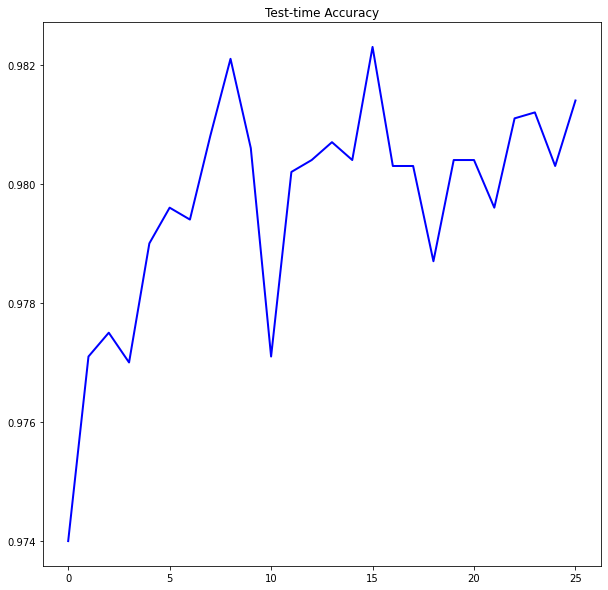

In [104]:
epochs_range = [i for i in range(26)] # last epoch was at 26
plt.figure(figsize = (10,10))
plt.plot(epochs_range, valid_accuracy_all_q2, color="blue", linewidth=2)
plt.title('Test-time Accuracy')
plt.show()

In [105]:
# torch.save(q2_weights_baseline, '/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q2 Finetuned Weights')


## Problem 3: SVD on every Epoch

In [78]:
# Load previous weights
q1_net = None
q1_net = baseline_q1()
q1_net.load_state_dict( torch.load('/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q1 Baseline Weights', map_location=torch.device('cpu')) )


<All keys matched successfully>

In [79]:
def get_low_rank_weights(w1, w2, w3, w4, w5):
  
  U1, S1, V_t1 = torch.linalg.svd(w1)
  U1, S1, V_t1 = U1.detach().cpu().numpy(), S1.detach().cpu().numpy(), V_t1.detach().cpu().numpy()

  U2, S2, V_t2 = torch.linalg.svd(w2)
  U2, S2, V_t2 = U2.detach().cpu().numpy(), S2.detach().cpu().numpy(), V_t2.detach().cpu().numpy()

  U3, S3, V_t3 = torch.linalg.svd(w3)
  U3, S3, V_t3 = U3.detach().cpu().numpy(), S3.detach().cpu().numpy(), V_t3.detach().cpu().numpy()

  U4, S4, V_t4 = torch.linalg.svd(w4)
  U4, S4, V_t4 = U4.detach().cpu().numpy(), S4.detach().cpu().numpy(), V_t4.detach().cpu().numpy()

  U5, S5, V_t5 = torch.linalg.svd(w5)
  U5, S5, V_t5 = U5.detach().cpu().numpy(), S5.detach().cpu().numpy(), V_t5.detach().cpu().numpy()

  w1_hat = torch.tensor(convert_low_rank_matrix(20, U1, S1, V_t1))
  w2_hat = torch.tensor(convert_low_rank_matrix(20, U2, S2, V_t2))
  w3_hat = torch.tensor(convert_low_rank_matrix(20, U3, S3, V_t3))
  w4_hat = torch.tensor(convert_low_rank_matrix(20, U4, S4, V_t4))
  w5_hat = torch.tensor(convert_low_rank_matrix(20, U5, S5, V_t5))

  return w1_hat, w2_hat, w3_hat, w4_hat, w5_hat

In [80]:
class low_rank_nn_q3(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fp_output = nn.Linear(1024, 10)
        
    def forward(self, input):
        input = self.fp_output(input)

        # MOST IMPORTANT REALIZATION...USE SOFTMAX AFTER CALCULATING CCE LOSS, THE CCE LOSS EXPECTS LOGITS AND NOT SOFTMAX OUTPUTS.
        return input    

In [81]:
class low_rank_nn_q3(nn.Module):
    
    def __init__(self, w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5):
      super().__init__()
      self.w_input_hat = nn.Parameter(w_input_hat, requires_grad=True)
      self.w2_hat = nn.Parameter(w2_hat, requires_grad=True)
      self.w3_hat = nn.Parameter(w3_hat, requires_grad=True)
      self.w4_hat = nn.Parameter(w4_hat, requires_grad=True)
      self.w5_hat = nn.Parameter(w5_hat, requires_grad=True)

      self.bias_input = nn.Parameter(bias_input, requires_grad=True)
      self.bias2 = nn.Parameter(bias2, requires_grad=True)
      self.bias3 = nn.Parameter(bias3, requires_grad=True)
      self.bias4 = nn.Parameter(bias4, requires_grad=True)
      self.bias5 = nn.Parameter(bias5, requires_grad=True)

      self.ReLU = nn.ReLU()
      self.fp_output = nn.Linear(1024, 10)
      
    def forward(self, x1 ): # x1, w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5
      z1 = torch.matmul( x1, self.w_input_hat.T) + self.bias_input
      x2 = self.ReLU(z1)

      z2 = torch.matmul(x2, self.w2_hat.T) + self.bias2
      x3 = self.ReLU(z2)

      z3 = torch.matmul(x3, self.w3_hat.T) + self.bias3
      x4 = self.ReLU(z3)

      z4 = torch.matmul(x4, self.w4_hat.T) + self.bias4
      x5 = self.ReLU(z4)
      
      z5 = torch.matmul(x5, self.w5_hat) + self.bias5
      x_output = self.ReLU(z5)
    
      y = self.fp_output(x_output)

      all_x = [x1, x2, x3, x4, x5, x_output] # list of 6

      # MOST IMPORTANT REALIZATION...USE SOFTMAX AFTER CALCULATING CCE LOSS, THE CCE LOSS EXPECTS LOGITS AND NOT SOFTMAX OUTPUTS.
      return y, all_x    

In [82]:
# def get_relu_derivative(z):
#   z[z<=0] = 0
#   z[z>0] = 1
#   return z

# def custom_feedforward(x1, w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5):
#   ReLU = nn.ReLU()
#   z1 = torch.matmul( x1, w_input_hat.T) + bias_input
#   x2 = ReLU(z1)

#   z2 = torch.matmul(x2, w2_hat.T) + bias2
#   x3 = ReLU(z2)

#   z3 = torch.matmul(x3, w3_hat.T) + bias3
#   x4 = ReLU(z3)

#   z4 = torch.matmul(x4, w4_hat.T) + bias4
#   x5 = ReLU(z4)
  
#   z5 = torch.matmul(x5, w5_hat) + bias5
#   x_output = ReLU(z5) # x_output is input to last layer (softmax layer)

#   # Append all x and weight values to list of list
#   all_x = [x1, x2, x3, x4, x5, x_output] # list of 6
#   all_z = [z1, z2, z3, z4, z5] # list of 6
#   all_w = [w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat] # list of 5
#   all_bias = [bias_input, bias2, bias3, bias4, bias5] # list of 5

#   return all_x, all_z, all_w, all_bias

# def custom_backpropagation(x_layers, z_layers, w_layers, bias_layers, gradient_backward, lr): # Need list of x_layer of each layer, and their weights - from input layer to (excluding) last layer, till hidden layer 5
#   for i in range(4, -1, -1): 
#     # iterate from last to first (6th or softmax layer is already done by torch function)
#     # For weights
#     # torch.Size([1024, 1024]) torch.Size([10, 1024]) torch.Size([10, 1024]) torch.Size([1024, 128]) torch.Size([1024, 128])
#     print( w_layers[i].shape, w_layers[i+1].shape,  gradient_backward.shape, x_layers[i].shape, z_layers[i].shape)

#     gradient_current =  torch.matmul(w_layers[i+1].T, gradient_backward) * get_relu_derivative(z_layers[i])
#     w_layers[i] = w_layers[i] - lr*(torch.matmul(gradient_current, x_layers[i].T))*torch.eye(w_layers[i].shape[0], w_layers[i].shape[1])
    
#     # For bias
#     # bias[j] -= gamma_bias * 1 * delta[j]
#     bias_layers[i] = bias_layers[i] - lr*gradient_current*1 # input is just 1

#     gradient_backward = gradient_current

#   return w_layers, bias_layers



In [83]:
def run_custom_network(net, w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5, epochs, loss_criteria, optimizer, learning_rate, validation_process=True):
  # A minor difference is that the implementation of CrossEntrypyLoss implicitly applies a softmax activation followed by a log transformation 
  # but NLLLoss does not.
  # To keep best performance value
  max_performance = float('-inf')
  
  # For early stopping
  tolerance_level = 0
  early_stopping_activated = 0
  epoch = 0
  MAX_MODEL = None
  MAX_PERFORMANCE_WEIGHTS = None

  train_loss_all = []
  valid_loss_all = []
  train_accuracy_all = []
  valid_accuracy_all = []

  print(len(train_loader))

  # # Set all initial parameters to random values
  # bias_input = torch.rand(1)
  # bias2 = torch.rand(1)
  # bias3 = torch.rand(1)
  # bias4 = torch.rand(1)
  # bias5 = torch.rand(1)
  # w1 = q1_net.fp_input.weight
  # w2 = q1_net.fp1.weight
  # w3 = q1_net.fp2.weight
  # w4 = q1_net.fp3.weight
  # w5 = q1_net.fp4.weight
  # w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat = get_low_rank_weights(w1, w2, w3, w4, w5) # get the weights from baseline model
   

  while( epoch <= epochs and early_stopping_activated == 0 ):
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    val_acc = 0
    
    # Training Part
    # Always have this line to ensure proper training
    net.train()
    actual_labels_train = []
    pred_labels_train = []
    all_targets = []
    all_preds = []

    for i, (data, actual) in enumerate(train_loader):
        # Reshape to single dimension
        data = data.reshape(-1, 784).float()

        # Push all variables to cuda
        if(torch.cuda.is_available()):
            data, actual =  data.to(device), actual.to(device)

        output, all_x = net.forward(data) # , w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5

        loss =  loss_criteria(output, actual)
        train_loss += loss.item()
        loss.backward()

        # Update weights manually
        with torch.no_grad():
          w5_hat = net.w5_hat - learning_rate*net.w5_hat.grad* 1
          w4_hat = net.w4_hat - learning_rate*net.w4_hat.grad* 1
          w3_hat = net.w3_hat - learning_rate*net.w3_hat.grad* 1
          w2_hat = net.w2_hat - learning_rate*net.w2_hat.grad* 1
          w_input_hat = net.w_input_hat - learning_rate*net.w_input_hat.grad*1
          
          # net.w5_hat = net.w5_hat - learning_rate*torch.matmul(net.w5_hat.grad, all_x[4].T)*torch.ones(net.w5_hat.shape[0], net.w5_hat.shape[1])
          # net.w4_hat = net.w4_hat - learning_rate*torch.matmul(net.w4_hat.grad, all_x[3].T)*torch.ones(net.w4_hat.shape[0], net.w4_hat.shape[1])
          # net.w3_hat = net.w3_hat - learning_rate*torch.matmul(net.w3_hat.grad, all_x[2].T)*torch.ones(net.w3_hat.shape[0], net.w3_hat.shape[1])
          # net.w2_hat = net.w2_hat - learning_rate*torch.matmul(net.w2_hat.grad, all_x[1].T)*torch.ones(net.w2_hat.shape[0], net.w2_hat.shape[1])
          # net.w_input_hat = net.w_input_hat - learning_rate*torch.matmul(net.w_input_hat.grad, all_x[0].T)*torch.ones(net.w_input_hat.shape[0], net.w_input_hat.shape[1])
          
          # For bias update
          bias_input = net.bias_input - learning_rate*net.bias_input.grad*1 # input is just 1
          bias2 = net.bias2 - learning_rate*net.bias2.grad*1 # input is just 1
          bias3 = net.bias3 - learning_rate*net.bias3.grad*1 # input is just 1
          bias4 = net.bias4 - learning_rate*net.bias4.grad*1 # input is just 1
          bias5 = net.bias5 - learning_rate*net.bias5.grad*1 # input is just 1
        
        # Perform SVD compression with updated weights
        w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat = get_low_rank_weights(w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat)
        
        if(torch.cuda.is_available()):
            w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat =  w_input_hat.to(device), w2_hat.to(device), w3_hat.to(device), w4_hat.to(device), w5_hat.to(device)
            bias_input, bias2, bias3, bias4, bias5 =  bias_input.to(device), bias2.to(device), bias3.to(device), bias4.to(device), bias5.to(device)

        # Now set and change weights of network to these low-rank approximated weights
        with torch.no_grad():
          net.w_input_hat = nn.Parameter(w_input_hat, requires_grad=True)
          net.w2_hat = nn.Parameter(w2_hat, requires_grad=True)
          net.w3_hat = nn.Parameter(w3_hat, requires_grad=True)
          net.w4_hat = nn.Parameter(w4_hat, requires_grad=True)
          net.w5_hat = nn.Parameter(w5_hat, requires_grad=True)

          net.bias_input = nn.Parameter(bias_input, requires_grad=True)
          net.bias2 = nn.Parameter(bias2, requires_grad=True)
          net.bias3 = nn.Parameter(bias3, requires_grad=True)
          net.bias4 = nn.Parameter(bias4, requires_grad=True)
          net.bias5 = nn.Parameter(bias5, requires_grad=True)


        optimizer.zero_grad()
        optimizer.step()

        # print('after update',w_input_hat, 'and', net.w_input_hat, 'also', any(any(row) for row in net.w_input_hat != temp))
          
        # Make Predictions at every epoch
        train_predictions = func.softmax(output, dim = 1).argmax(dim=1, keepdim=True)
        actual_labels_train.append(actual.cpu().numpy())
        pred_labels_train.append(train_predictions.cpu().numpy())
        
    all_targets = np.concatenate(actual_labels_train, axis=0)
    all_preds = np.concatenate(pred_labels_train, axis=0)
    train_acc = accuracy_score(all_preds, all_targets)
    train_accuracy_all.append(train_acc)

    # Evaluation Part
    # Always have this line to ensure proper evaluation 
    if(validation_process):
      net.eval()
      
      actual_labels_all = []
      pred_labels_all = []
      all_targets = []
      all_preds = []
      # Now do validation and keep track of valid loss
      with torch.no_grad():
          for i, (data, labels) in enumerate(valid_loader):
              # Reshape to single dimension
              data = data.reshape(-1, 784)

              if(torch.cuda.is_available()):
                  data, labels = data.float().to(device), labels.to(device)

              # FP     
              val_logits, _ = net.forward(data)
              v_loss = loss_criteria(val_logits, labels)
              valid_loss += v_loss.item()
              val_predictions = func.softmax(val_logits, dim = 1).argmax(dim=1, keepdim=True)
              actual_labels_all.append(labels.cpu().numpy())
              pred_labels_all.append(val_predictions.cpu().numpy())
              
      all_targets = np.concatenate(actual_labels_all, axis=0)
      all_preds = np.concatenate(pred_labels_all, axis=0)
      val_acc = accuracy_score(all_preds, all_targets)
      valid_accuracy_all.append(val_acc)
      
    if(epoch % 1 == 0):
      print(f'Epoch {epoch} \t Train loss(on avg per batch): {round(train_loss/len(train_loader), 6) } \t Train Accuracy: {round(train_acc*100, 6)}% \t Validation loss(on avg per batch): {round(valid_loss/len(valid_loader),6)} \t Validation Accuracy: {round(val_acc*100,6)}%')

    train_loss_all.append(train_loss/len(train_loader))
    valid_loss_all.append(valid_loss/len(valid_loader)) 
    
    if(val_acc*100 > max_performance):
        max_performance = val_acc*100
        tolerance_level = 0
        # Save Model
        MAX_PERFORMANCE_WEIGHTS = net.state_dict()
        MAX_MODEL = net
        
    else:
        tolerance_level+=1
        if(tolerance_level >= 10):
            early_stopping_activated = 1
            print('Early Stopping activated - no improvement in validation accuracy for the past 10 epochs. Using model stage before 10 epochs for further use!')
    
    epoch+=1

  if(not validation_process):
      # Save Model at end
      MAX_PERFORMANCE_WEIGHTS = net.state_dict()
      MAX_MODEL = net

  print('Best Performance on Validation data achived till now :', max_performance)
  
  return MAX_MODEL, MAX_PERFORMANCE_WEIGHTS, train_accuracy_all, valid_accuracy_all

In [84]:

# Set all initial parameters to random values
bias_input = torch.rand(1)
bias2 = torch.rand(1)
bias3 = torch.rand(1)
bias4 = torch.rand(1)
bias5 = torch.rand(1)
w1 = q1_net.fp_input.weight
w2 = q1_net.fp1.weight
w3 = q1_net.fp2.weight
w4 = q1_net.fp3.weight
w5 = q1_net.fp4.weight
w_input_hat, w2_hat, w3_hat, w4_hat, w5_hat = get_low_rank_weights(w1, w2, w3, w4, w5) # get the weights from baseline model


net = None
net = low_rank_nn_q3( w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5)
if(torch.cuda.is_available()):
  net = net.float().to(device)
else:
  net = net.float()
loss_func = nn.CrossEntropyLoss() # Here Sparse CLE is correct, but in pytorch nn.CrossEntropyLoss accepts ground truth labels directly as integers in [0, N_CLASSES] (no need to onehot encode the labels):
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
print(net)
torch.cuda.empty_cache()

q3_net_baseline, q3_weights_baseline, train_accuracy_all_baseline, valid_accuracy_all_baseline = run_custom_network(net, w_input_hat, bias_input, w2_hat, bias2, w3_hat, bias3, w4_hat, bias4, w5_hat, bias5, epochs = 10, loss_criteria = loss_func, optimizer = optimizer, learning_rate = 0.001, validation_process=True)


low_rank_nn_q3(
  (ReLU): ReLU()
  (fp_output): Linear(in_features=1024, out_features=10, bias=True)
)
469
Epoch 0 	 Train loss(on avg per batch): 1.499019 	 Train Accuracy: 55.895% 	 Validation loss(on avg per batch): 1.128224 	 Validation Accuracy: 65.59%
Epoch 1 	 Train loss(on avg per batch): 1.03626 	 Train Accuracy: 73.5% 	 Validation loss(on avg per batch): 0.959198 	 Validation Accuracy: 81.67%
Epoch 2 	 Train loss(on avg per batch): 0.905625 	 Train Accuracy: 83.188333% 	 Validation loss(on avg per batch): 0.855965 	 Validation Accuracy: 83.28%
Epoch 3 	 Train loss(on avg per batch): 0.808072 	 Train Accuracy: 84.576667% 	 Validation loss(on avg per batch): 0.764874 	 Validation Accuracy: 84.94%
Epoch 4 	 Train loss(on avg per batch): 0.718181 	 Train Accuracy: 86.031667% 	 Validation loss(on avg per batch): 0.680066 	 Validation Accuracy: 86.43%
Epoch 5 	 Train loss(on avg per batch): 0.634921 	 Train Accuracy: 87.931667% 	 Validation loss(on avg per batch): 0.602201 	 Valida

#### We see here although the accuracy is not as high as using the original matrix, this method of network compression is effective in reducing memory usage and also just a little drop in performance.

In [85]:
# torch.save(q3_weights_baseline, '/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q3 Weights')


## Problem 4: Speaker Verification

In [7]:
with open(folder_path + 'hw4_trs.pkl', 'rb') as f:
  x_train = pickle.load(f)

with open(folder_path + 'hw4_tes.pkl', 'rb') as f:
    x_test = pickle.load(f)

In [8]:
print('Training speaker audio loaded', x_train.shape)
print('Test speaker audio loaded', x_test.shape)

Training speaker audio loaded (500, 16180)
Test speaker audio loaded (200, 22631)


In [9]:

x_train_stft = np.zeros(shape=(500,50,513)) 
# Maximum length allowed is 50 (there is 45 length audio in test, so pad there with and train with extra zeroes)
for i in range(x_train.shape[0]):
    x = x_train[i,:]
    X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    x_train_stft[i,:,:] = np.pad(X,((0,50 - X.shape[0]),(0,0)), 'constant')
print(x_train_stft.shape)

x_test_stft = np.zeros(shape=(200,50,513))
for i in range(x_test.shape[0]):
  x = x_test[i,:]
  X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
  X = np.abs(X_complex).T
  x_test_stft[i,:,:] = np.pad(X,((0,50 - X.shape[0]),(0,0)), 'constant')
print(x_test_stft.shape)

# Preprocess target data
y_train = np.zeros((500,1))
count=0
for i in range(0,50): # 50 speakers in train data, take each of them
  for j in range(0,10): # Each with 10 utterences
    y_train[count]=i
    count+=1
print(y_train.shape)

y_test = np.zeros((200,1))
count=0
for i in range(0,20): # Each of 20 speakers in test data
  for j in range(0,10): # Each with 10 utterences
    y_test[count]=i
    count+=1
print(y_test.shape)

(500, 50, 513)
(200, 50, 513)
(500, 1)
(200, 1)


In [10]:
positive_samples = 45
negative_samples = 45

y_train = np.array(y_train)
x_idx = np.arange(0,len(y_train)).reshape(-1,1)
speaker_count_train = np.unique(y_train)
train_pairs = []
train_labels = []
for speaker in speaker_count_train:
  spk_idx = x_idx[np.where(y_train==speaker)] # Get all index where speaker is i
  rest_spk_idx = x_idx[np.where(y_train!=speaker)]

  pos_pairs = random.sample(list(combinations(spk_idx,2)),positive_samples) # WITHOUT REPALCEMENT
  for pair in pos_pairs:
    audio_stft_1 = x_train_stft[pair[0],:,:]
    audio_stft_2 = x_train_stft[pair[1],:,:]
    train_pairs.append( [audio_stft_1,audio_stft_2] )
    train_labels.append(1)

  neg_pairs = random.sample(list(product(spk_idx,rest_spk_idx)),negative_samples) # WITHOUT REPALCEMENT
  for pair in neg_pairs:
    audio_stft_1 = x_train_stft[pair[0],:,:]
    audio_stft_2 = x_train_stft[pair[1],:,:]
    train_pairs.append([audio_stft_1,audio_stft_2])
    train_labels.append(0)    

train_pairs, train_labels = np.array(train_pairs).astype("float"), np.array(train_labels).astype("float")
    
print(train_pairs.shape)
print(train_labels.shape)

(4500, 2, 50, 513)
(4500,)


In [11]:
# 4500 data, each is a pair of two vectors and each of those vecotrs is 50, 513. While bassing in batches, we can pass 128, 2, 50, 513
train_pairs[0].shape

(2, 50, 513)

In [12]:
positive_samples = 45
negative_samples = 45

y_test = np.array(y_test)
x_idx = np.arange(0,len(y_test)).reshape(-1,1)
speaker_count_test = np.unique(y_test)
test_pairs = []
test_labels = []
for speaker in speaker_count_test:
  spk_idx = x_idx[np.where(y_test==speaker)] # Get all index where speaker is i
  rest_spk_idx = x_idx[np.where(y_test!=speaker)]

  pos_pairs = random.sample(list(combinations(spk_idx,2)),positive_samples) # WITHOUT REPALCEMENT
  for pair in pos_pairs:
    audio_stft_1 = x_test_stft[pair[0],:,:]
    audio_stft_2 = x_test_stft[pair[1],:,:]
    test_pairs.append( [audio_stft_1,audio_stft_2] )
    test_labels.append(1)

  neg_pairs = random.sample(list(product(spk_idx,rest_spk_idx)),negative_samples) # WITHOUT REPALCEMENT
  for pair in neg_pairs:
    audio_stft_1 = x_test_stft[pair[0],:,:]
    audio_stft_2 = x_test_stft[pair[1],:,:]
    test_pairs.append([audio_stft_1,audio_stft_2])
    test_labels.append(0)    

test_pairs,test_labels = np.array(test_pairs).astype("float"), np.array(test_labels).astype("float")
    
print(test_pairs.shape)
print(test_labels.shape)

(1800, 2, 50, 513)
(1800,)


In [13]:
# Dataloader creation
batch_size_train = 90 # batch size train set
batch_size_test = 90 # batch size test set
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_pairs), torch.tensor(train_labels) )
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(test_pairs), torch.tensor(test_labels) )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size_train, 
                                             shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                             batch_size=batch_size_test, 
                                             shuffle=False)


In [38]:
class siamese_q3(nn.Module):
    
    def __init__(self):
        super().__init__()

        # self.fp_input = nn.Linear(28*28, 1024)
        self.gru1 = nn.GRU(input_size = 513, hidden_size = 256, num_layers = 2, bidirectional=True) # bidirectional=True sets both ways for parsing
        self.fp1 = nn.Linear( int(512*50), 512 ) # 2 for bidirectional=True
        self.fp2 = nn.Linear( 512, 256 )
        self.fp_output = nn.Linear(90, 1)
        self.ReLU = nn.ReLU()
        
    def forward(self, input):
        to_save_layerop = {}
        x1 = input[:, 0, :, :]
        x2 = input[:, 1, :, :]

        # Simaese network with two audio spectra processed parallelly
        input1, _ = self.gru1(x1)
        input1 = torch.flatten(input1, start_dim = 1)        
        input1 = self.fp1(input1)
        input1 = self.ReLU(input1)
        input1 = self.fp2(input1)
        input1 = self.ReLU(input1)

        input2, _ = self.gru1(x2) # Since we use shared weights for gru, both inputs have same gru
        input2 = torch.flatten(input2, start_dim = 1)        
        input2 = self.fp1(input2)
        input2 = self.ReLU(input2)
        input2 = self.fp2(input2)
        input2 = self.ReLU(input2)

        # Inner product of these two vectors will be used for binary-classification
        # inner_prod = torch.matmul(input1, input2.T)
        inner_prod = torch.cdist(input1, input2, p = 2)
        # print(ed.shape)

        input = self.fp_output(inner_prod)
        # to_save_layerop['fp_output_before_softmax'] = input

        # MOST IMPORTANT REALIZATION...USE SOFTMAX AFTER CALCULATING CCE LOSS, THE CCE LOSS EXPECTS LOGITS AND NOT SOFTMAX OUTPUTS.
        return input, to_save_layerop    

In [48]:
def run_network(net, epochs, loss_criteria, optimizer, validation_process=True):
    # A minor difference is that the implementation of CrossEntrypyLoss implicitly applies a softmax activation followed by a log transformation 
    # but NLLLoss does not.

    # To keep best performance value
    max_performance = float('-inf')
    
    # For early stopping
    tolerance_level = 0
    early_stopping_activated = 0
    epoch = 0
    MAX_MODEL = None
    MAX_PERFORMANCE_WEIGHTS = None

    train_loss_all = []
    valid_loss_all = []
    train_accuracy_all = []
    valid_accuracy_all = []

    print(len(train_loader))

    while( epoch <= epochs and early_stopping_activated == 0 ):
        train_loss = 0
        valid_loss = 0
        train_acc = 0
        val_acc = 0
        
        # Training Part
        # Always have this line to ensure proper training
        net.train()
        actual_labels_train = []
        pred_labels_train = []
        all_targets = []
        all_preds = []

        for i, (data, actual) in enumerate(train_loader):
            # Push all variables to cuda
            if(torch.cuda.is_available()):
                data, actual =  data.float().to(device), actual.to(device)

            output, _ = net(data.float())
            actual = actual.reshape(-1,1)
            loss =  loss_criteria(output, actual)
            # Track loss
            train_loss += loss.item()
            train_predictions = torch.sigmoid(output)
            train_predictions = (train_predictions>0.5).float()*1  
            actual_labels_train.append(actual.cpu().numpy())
            pred_labels_train.append(train_predictions.cpu().numpy())

            optimizer.zero_grad() # reset gradients
            loss.backward()
            optimizer.step()

        all_targets = np.concatenate(actual_labels_train, axis=0)
        all_preds = np.concatenate(pred_labels_train, axis=0)
        train_acc = accuracy_score(all_preds, all_targets)
        train_accuracy_all.append(train_acc)


        # Evaluation Part
        # Always have this line to ensure proper evaluation 
        if(validation_process):
          net.eval()
          
          actual_labels_all = []
          pred_labels_all = []
          all_targets = []
          all_preds = []
          # Now do validation and keep track of valid loss
          with torch.no_grad():
              for i, (data, labels) in enumerate(valid_loader):
                  if(torch.cuda.is_available()):
                      data, labels = data.float().to(device), labels.to(device)

                  # FP     
                  val_logits, _ = net.forward(data)
                  labels = labels.reshape(-1,1)
                  v_loss = loss_criteria(val_logits, labels)
                  valid_loss += v_loss.item()
                  val_predictions = torch.sigmoid(val_logits)
                  val_predictions = (val_predictions>0.5).float()*1 
                  actual_labels_all.append(labels.cpu().numpy())
                  pred_labels_all.append(val_predictions.cpu().numpy())
                  
          all_targets = np.concatenate(actual_labels_all, axis=0)
          all_preds = np.concatenate(pred_labels_all, axis=0)
          val_acc = accuracy_score(all_preds, all_targets)
          valid_accuracy_all.append(val_acc)
          
          if(epoch % 1 == 0):
            print(f'Epoch {epoch} \t Train loss(on avg per batch): {round(train_loss/len(train_loader), 6) } \t Train Accuracy: {round(train_acc*100, 6)}% \t Validation loss(on avg per batch): {round(valid_loss/len(valid_loader),6)} \t Validation Accuracy: {round(val_acc*100,6)}%')

          train_loss_all.append(train_loss/len(train_loader))
          valid_loss_all.append(valid_loss/len(valid_loader)) 
          
          if(val_acc*100 > max_performance):
              max_performance = val_acc*100
              MAX_PERFORMANCE_WEIGHTS = net.state_dict()
              MAX_MODEL = net
              
          # else:
          #     tolerance_level+=1
          #     if(tolerance_level >= 10):
          #         early_stopping_activated = 1
          #         print('Early Stopping activated - no improvement in validation accuracy for the past 10 epochs. Using model stage before 10 epochs for further use!')
        epoch+=1

    if(not validation_process):
        # Save Model at end
        MAX_PERFORMANCE_WEIGHTS = net.state_dict()
        MAX_MODEL = net

    print('Best Performance on Validation data achived till now :', max_performance)
    
    return MAX_MODEL, MAX_PERFORMANCE_WEIGHTS, train_accuracy_all, valid_accuracy_all

In [49]:
net = None
net = siamese_q3()
if(torch.cuda.is_available()):
  net = net.float().to(device)
else:
  net = net.float()
# net.apply(he_weights) # ContrastiveLoss # BCEWithLogitsLoss
loss_func = nn.BCEWithLogitsLoss() # Here Sparse CLE is correct, but in pytorch nn.CrossEntropyLoss accepts ground truth labels directly as integers in [0, N_CLASSES] (no need to onehot encode the labels):
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
print(net)
torch.cuda.empty_cache()

q4_net_siamese, q4_weights_siamese, train_accuracy_all_siamese, valid_accuracy_all_siamese = run_network(net, epochs = 100, loss_criteria = loss_func, optimizer = optimizer)

siamese_q3(
  (gru1): GRU(513, 256, num_layers=2, bidirectional=True)
  (fp1): Linear(in_features=25600, out_features=512, bias=True)
  (fp2): Linear(in_features=512, out_features=256, bias=True)
  (fp_output): Linear(in_features=90, out_features=1, bias=True)
  (ReLU): ReLU()
)
50
Epoch 0 	 Train loss(on avg per batch): 0.715402 	 Train Accuracy: 48.711111% 	 Validation loss(on avg per batch): 0.756884 	 Validation Accuracy: 52.388889%
Epoch 1 	 Train loss(on avg per batch): 0.701141 	 Train Accuracy: 49.533333% 	 Validation loss(on avg per batch): 0.689233 	 Validation Accuracy: 51.5%
Epoch 2 	 Train loss(on avg per batch): 0.699673 	 Train Accuracy: 49.266667% 	 Validation loss(on avg per batch): 0.687278 	 Validation Accuracy: 55.333333%
Epoch 3 	 Train loss(on avg per batch): 0.694773 	 Train Accuracy: 50.088889% 	 Validation loss(on avg per batch): 0.692849 	 Validation Accuracy: 52.222222%
Epoch 4 	 Train loss(on avg per batch): 0.693772 	 Train Accuracy: 50.266667% 	 Validation

## I am still not sure why the accuracy won't go up, I am not sure if the model is getting trained properly - please let me know what other techniques I can use to increase the validation accuracy. The weights are getting updated, so that is not the issue.

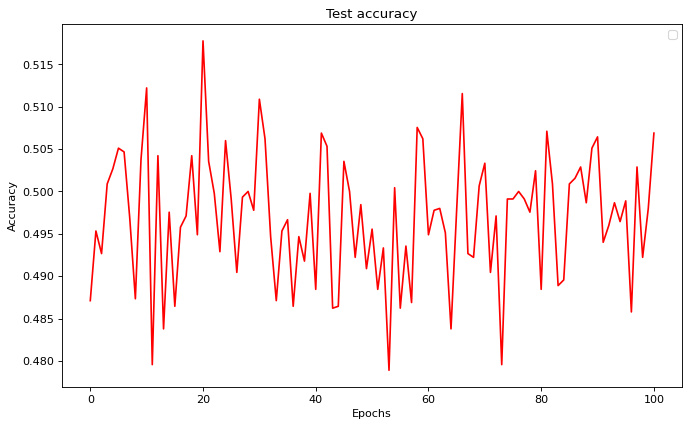

In [50]:
figure(figsize=(10, 6), dpi=80)
plt.plot(range(0, len(train_accuracy_all_siamese)), train_accuracy_all_siamese, color = 'red')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
torch.save(q4_weights_siamese, '/content/drive/My Drive/Projects and research stuffs/DLS Assignments/Assignment 4/Q4 Weights Siamese')
